# ASL Sign Language Detection Using ViT

### Relevant Imports

In [1]:
import os
from zipfile import ZipFile, Path
import csv
import pandas as pd
import numpy as np
from PIL import Image
from skimage import io
from contextlib import contextmanager
from matplotlib import pyplot as plt


import torch
from torch import nn
from torch.utils import data as tdata
from torchvision import utils as vutils, transforms as T

In [2]:
# keep this at 0 on windows
num_workers = 0

### Custom Datasets

- Below, we implement custom datasets where we can read directly from zip files without actually unzipping them.

In [3]:
# path of zip file
zip_path = 'archive.zip'

# path of training dir in the zip file
train_path = 'asl_alphabet_train/asl_alphabet_train/'

# file where (path, target will be stored)
info_path = './info.csv'

def get_dirs_and_count(zip_path, dir_path, info_path):
  """Is useful for getting directory list, counts etc

  Args:
      zip_path (str): _description_
      dir_path (str): _description_

  Returns:
      `Tuple[List[str], Dict[str, int], Dict[str, int]]`: \n
      1. List of directories, 2. dictionary that maps those directories to the index in that list, 3. Dictionary that holds `(path, target)`
  """

  with ZipFile(zip_path, 'r') as f:
    path = Path(f, dir_path)

    # stores a `Path` object for each directory in the mentioned `dir_path`
    dirs = [x for x in path.iterdir() if x.is_dir()]

    # stores each file's path to it's target class
    path_to_class = {}

    for i, d in enumerate(dirs):
      # we need to iterate over the files in `d` and write `(file_path, target)`

      for f in d.iterdir():
        path_to_class[f"{train_path}{d.name}/{f.name}"] = i

    # we convert each path like object to the actual directory name
    dirs = [x.name for x in dirs]

    # is like classes_to_idx
    dir_to_i = {d: i for i, d in enumerate(dirs)}

  # below code writes to an info csv in the format `path,target`
  if not os.path.exists(info_path) and info_path is not None:
    with open(info_path, 'w') as f:
      w = csv.writer(f)
      w.writerows(path_to_class.items())

  return dirs, dir_to_i, path_to_class


print(str(get_dirs_and_count(zip_path, train_path, info_path))[:1000])


(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space'], {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}, {'asl_alphabet_train/asl_alphabet_train/A/A1.jpg': 0, 'asl_alphabet_train/asl_alphabet_train/A/A10.jpg': 0, 'asl_alphabet_train/asl_alphabet_train/A/A100.jpg': 0, 'asl_alphabet_train/asl_alphabet_train/A/A1000.jpg': 0, 'asl_alphabet_train/asl_alphabet_train/A/A1001.jpg': 0, 'asl_alphabet_train/asl_alphabet_train/A/A1002.jpg': 0, 'asl_alphabet_train/asl_alphabet_train/A/A1003.jpg': 0, 'asl_alphabet_train/asl_alphabet_train/A/A1004.jpg': 0, 'asl_alphabet_train/asl_alphabet_train/A/A1005.jpg': 0, 'asl_alphabet_train/asl_alphabet_train/A/A1006.jpg': 0, 'asl_alphabet_train/

In [4]:
class _ImageZipDataset(tdata.Dataset):

  def __init__(self, zip_file: ZipFile, samples, transform=None) -> None:
    self.zip_file = zip_file
    self.samples = samples

    self.transform = transform


  def __getitem__(self, index):
    path, target = self.samples[index]

    with self.zip_file.open(path) as f:
      # sample = Image.open(f).convert('RGB')
      sample = io.imread(f)

    if self.transform is not None:
      sample = self.transform(sample)

    return sample, target

  def __len__(self):
    return len(self.samples)


In [5]:
class ImageZipDatasetWrapper(tdata.Dataset):

  def __init__(self, zip_path, dir_path, info_path, transform=None) -> None:

    if not os.path.exists(zip_path):
      raise FileNotFoundError("Provided zip file does not exist at path")

      
    self.zip_path = zip_path
    self.classes, self.classes_to_idx, _ = get_dirs_and_count(
        zip_path, dir_path, info_path)

    if not os.path.exists(info_path):
      raise FileNotFoundError("CSV File does not exist")
      
    self.samples = self.load_csv(info_path)
    self.transform = transform

  def load_csv(self, info_path):
    return pd.read_csv(info_path).to_numpy()

  @contextmanager
  def dataset(self):
    with ZipFile(self.zip_path, 'r') as z:
      res = _ImageZipDataset(
          zip_file=z,
          samples=self.samples,
          transform=self.transform
      )
      yield res

  def __len__(self):
    return len(self.samples)


In [6]:
data_transforms = T.Compose([T.ToTensor()])
train_dataset_wrapper = ImageZipDatasetWrapper(zip_path, train_path, info_path, transform=data_transforms)


### Defining utilities to plot images

In [7]:
def plot_image(tensor, label=None):
  """tensor is of shape `(h, w, c)`"""
  plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

  if label is not None:
    plt.title("Target digit: " + str(label))
  plt.imshow(tensor)

In [8]:
def plot_grid(tensor, n_row):
  """Input is of shape (batch_size, c, h, w)"""

  grid_tensor = vutils.make_grid(tensor, n_row).permute(1, 2, 0)
  plot_image(grid_tensor, "Grid of Random ASL Images")

torch.Size([64, 3, 200, 200])


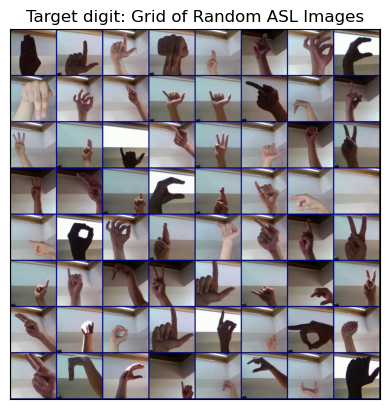

In [9]:
with train_dataset_wrapper.dataset() as dataset:

  dloader = tdata.DataLoader(dataset, 64, True, num_workers=num_workers)

  for i, (x, y) in enumerate(dloader):
    print(x.shape)
    plot_grid(x, 8)
    break


### Defining the model